Build our first neural network

1. MNIST Dataset
2. DataLoader and Transformations
3. Multi-layer Neural Network
4. Loss and Optimizer
5. Training loop (batch optimzer)
6. Model Evaluation
7. GPU support


In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import matplotlib.pyplot as plt

In [4]:
# Device configuration to use if GPU available and hyperparaters configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# tunable hyperparameters
hidden_size = 100        # this parameter can be tuned to affect the training accuracy 
num_epochs = 500         # this parameter can be tuned to affect the training accuracy
batch_size = 100         # this parameter can be tuned to affect the training accuracy
learning_rate = 0.001    # this parameter can be tuned to affect the training accuracy

# fixed parameters
input_size = 784        # images are 28x28 pixels, convert that in flattened 1-d tensor
num_classes = 10        # 10 different digits to classify: 0-9
print(device)

cpu


### Step 1 & 2. MNIST Dataset

In [5]:
# Download the training and test datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                          transform=transform.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                          transform=transform.ToTensor(), download=False)

# Define the Dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Get the first dataset as tensors and unpack it
examples = iter(train_loader)
features, labels = examples.next()

# samples=100 in our batch; 1 is the channel (not RGB); 28 x 28 is our image sizez
print(features.shape, labels.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])


Let's examine what our data looks like

In [6]:
%matplotlib inline

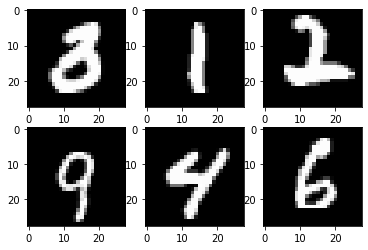

In [7]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(features[i][0], cmap='gray')
plt.show()

### Step 3. Multi-Layer Neural Network

In [8]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

In [9]:
# Create our model
model = NeuralNet(input_size, hidden_size, num_classes).to(device)
print(model)

NeuralNet(
  (l1): Linear(in_features=784, out_features=100, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=100, out_features=10, bias=True)
)


### Step 4. Loss and Optimizer

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Step 5 & 6. Train in batches and Evaluate

In [ ]:
# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')
